<h1 style='font-size:20px;text-align:center'>How to create a cloud shadow mask and detect cloud illuminated side for an Aqua/Modis granule ?</h1>

<p style='text-align: center'>
<br> Last Update: 2020-11-08
</p>




In [235]:
from ftplib import FTP
from matplotlib.pyplot import figure
from pyhdf.SD import SD, SDC 
from pyhdf.HDF import *
from pyhdf.VS import *
from os import path
from datetime import date
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns; sns.set()
import datetime 
import urllib.request
import urllib.request, json 
import pandas as pd
import os
import calendar
import numpy as np
import glob
import re
import pprint
import warnings

warnings.filterwarnings('ignore')

Replace ******** by your NASA LAADS DAAC App key (see [ladsweb](https://ladsweb.modaps.eosdis.nasa.gov/))

In [236]:
opener = urllib.request.build_opener()
opener.addheaders = [('Authorization', 'Bearer *****')]
urllib.request.install_opener(opener)

In [237]:
year = 2012
month = 10
day = 31
hour = 14
minute = 45

product = 'MYD021KM'

In [238]:
d0 = date(year, 1, 1)
d1 = date(year, month, day)
delta = d1 - d0

count_of_day = delta.days + 1

print(count_of_day)

305


In [239]:
%%time

ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/{}/{:04d}/{:03d}.json'.format(product,year,count_of_day)

with urllib.request.urlopen(ladsweb_url) as url:
    data = json.loads(url.read().decode())

#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(data)

CPU times: user 12.7 ms, sys: 2.42 ms, total: 15.1 ms
Wall time: 825 ms


In [240]:
type(data)

list

In [241]:
len(data)

288

In [242]:
data[0]

{'name': 'MYD021KM.A2012305.0000.061.2018042185847.hdf',
 'size': 147812488,
 'last-modified': '2018-06-10 23:20'}

In [243]:
file_name = ''
for file in data:
    #print(file['name'])
    file_name_prefix = '{}.A{:04d}{:03d}.{:02d}{:02d}'.format(product,year,count_of_day,hour,minute)
    if file_name_prefix in file['name']:
        file_name = file['name']      
        
print(file_name)

MYD021KM.A2012305.1445.061.2018042160148.hdf


In [244]:
if not path.exists(file_name):
    print('do something !')

In [245]:
if not path.exists(file_name):
    ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/{}/{:04d}/{:03d}/{}'.format(product,year,count_of_day,file_name)
    urllib.request.urlretrieve(ladsweb_url, file_name) 

{'long_name': 'Earth View 250M Aggregated 1km Reflective Solar Bands Scaled Integers', 'units': 'none', 'valid_range': [0, 32767], '_FillValue': 65535, 'band_names': '1,2', 'radiance_scales': [0.02518785372376442, 0.00857981014996767], 'radiance_offsets': [-0.0, -0.0], 'radiance_units': 'Watts/m^2/micrometer/steradian', 'reflectance_scales': [4.848260141443461e-05, 2.6789013645611703e-05], 'reflectance_offsets': [-0.0, -0.0], 'reflectance_units': 'none', 'corrected_counts_scales': [0.12497329711914062, 0.12497329711914062], 'corrected_counts_offsets': [-0.0, -0.0], 'corrected_counts_units': 'counts'}
{'long_name': 'Earth View 500M Aggregated 1km Reflective Solar Bands Scaled Integers', 'units': 'none', 'valid_range': [0, 32767], '_FillValue': 65535, 'band_names': '3,4,5,6,7', 'radiance_scales': [0.02428816631436348, 0.01898512989282608, 0.004948083311319351, 0.002716063056141138, 0.0008271835395134985], 'radiance_offsets': [-0.0, -0.0, -0.0, -0.0, -0.0], 'radiance_units': 'Watts/m^2/mi

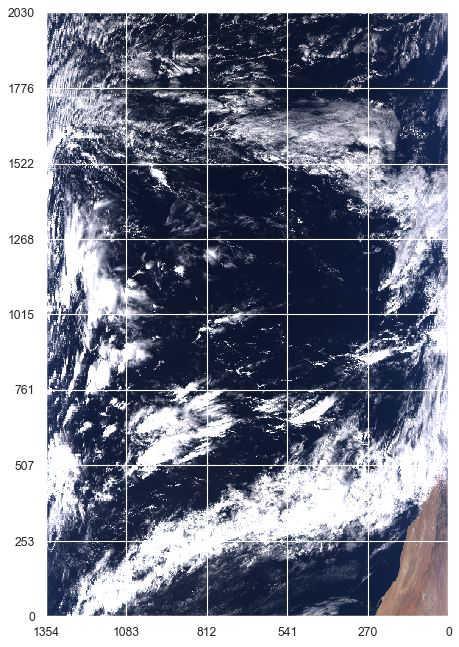

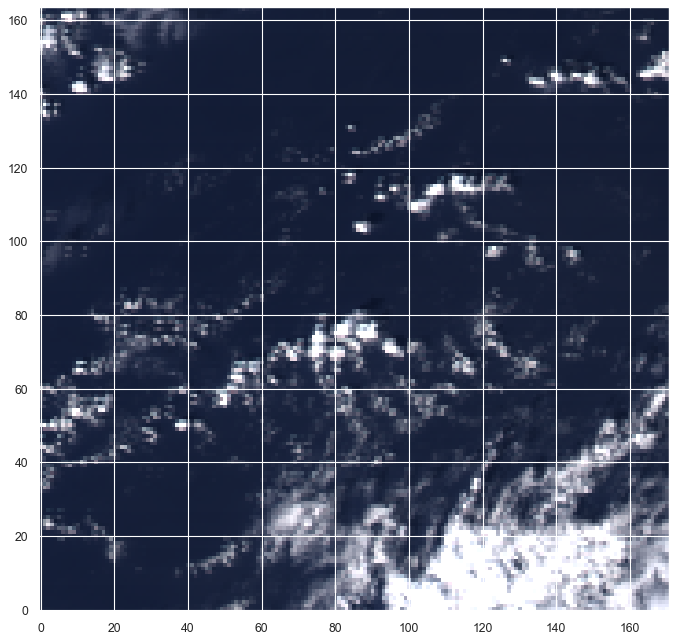

In [246]:
def plot_RGB_image(myd021km_file):

    selected_sds = myd021km_file.select('EV_250_Aggr1km_RefSB')

    selected_sds_attributes = selected_sds.attributes()
    
    print(selected_sds_attributes)
    
    for key, value in selected_sds_attributes.items():
        if key == 'reflectance_scales':
            reflectance_scales_250_Aggr1km_RefSB = np.asarray(value)
        if key == 'reflectance_offsets':
            reflectance_offsets_250_Aggr1km_RefSB = np.asarray(value)

    sds_data_250_Aggr1km_RefSB = selected_sds.get()




    selected_sds = myd021km_file.select('EV_500_Aggr1km_RefSB')

    selected_sds_attributes = selected_sds.attributes()
    
    print(selected_sds_attributes)
    
    for key, value in selected_sds_attributes.items():
        if key == 'reflectance_scales':
            reflectance_scales_500_Aggr1km_RefSB = np.asarray(value)
        if key == 'reflectance_offsets':
            reflectance_offsets_500_Aggr1km_RefSB = np.asarray(value)

    sds_data_500_Aggr1km_RefSB = selected_sds.get()

    print( reflectance_scales_500_Aggr1km_RefSB.shape)


    data_shape = sds_data_250_Aggr1km_RefSB.shape

    along_track = data_shape[1]
    cross_trak = data_shape[2]

    z = np.zeros((along_track, cross_trak,3))

    z[:,:,0] = ( sds_data_250_Aggr1km_RefSB[0,:,:] - reflectance_offsets_250_Aggr1km_RefSB[0] ) * reflectance_scales_250_Aggr1km_RefSB[0] 
    z[:,:,1] = ( sds_data_500_Aggr1km_RefSB[1,:,:] - reflectance_offsets_500_Aggr1km_RefSB[1] ) * reflectance_scales_500_Aggr1km_RefSB[1] 
    z[:,:,2] = ( sds_data_500_Aggr1km_RefSB[0,:,:] - reflectance_offsets_500_Aggr1km_RefSB[0] ) * reflectance_scales_500_Aggr1km_RefSB[0] 



    norme = 0.4 # factor to increase the brightness ]0,1]

    rgb = np.zeros((along_track, cross_trak,3))

    rgb = z / norme

    rgb[ rgb > 1 ] = 1.0
    rgb[ rgb < 0 ] = 0.0

    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

    img = plt.imshow(np.fliplr(rgb), interpolation='nearest', origin='lower')

    l = [int(i) for i in np.linspace(0,cross_trak,6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

    l = [int(i) for i in np.linspace(0,along_track,9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )

    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.title('', fontsize=16)

    plt.show()

    
 

    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

    img = plt.imshow(np.fliplr(rgb[293:457,912:1083]), interpolation='nearest', origin='lower')

    #l = [int(i) for i in np.linspace(0,cross_trak,6)]
    #plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

    #l = [int(i) for i in np.linspace(0,along_track,9)]
    #plt.yticks(l, l, rotation=0, fontsize=11 )

    #plt.xticks(fontsize=11)
    #plt.yticks(fontsize=11)

    plt.title('', fontsize=16)

    plt.show()

    
    plt.close()

myd021km_file = SD(file_name, SDC.READ)
    
plot_RGB_image(myd021km_file)

In [247]:
product = 'MYD02HKM'

In [248]:
%%time

ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/{}/{:04d}/{:03d}.json'.format(product,year,count_of_day)

with urllib.request.urlopen(ladsweb_url) as url:
    data = json.loads(url.read().decode())

#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(data)

CPU times: user 12.7 ms, sys: 1.69 ms, total: 14.4 ms
Wall time: 609 ms


In [249]:
file_name = ''
for file in data:
    #print(file['name'])
    file_name_prefix = '{}.A{:04d}{:03d}.{:02d}{:02d}'.format(product,year,count_of_day,hour,minute)
    if file_name_prefix in file['name']:
        file_name = file['name']      
        
print(file_name)

MYD02HKM.A2012305.1445.061.2018042160148.hdf


In [250]:
if not path.exists(file_name):
    ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/{}/{:04d}/{:03d}/{}'.format(product,year,count_of_day,file_name)
    urllib.request.urlretrieve(ladsweb_url, file_name) 

In [251]:
'''myd02hkm_file = SD(file_name, SDC.READ)
    
datasets_dic = myd02hkm_file.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    print( idx,sds )
    
selected_sds = myd021km_file.select('EV_250_Aggr500_RefSB')

selected_sds_attributes = selected_sds.attributes()

print(selected_sds_attributes)

for key, value in selected_sds_attributes.items():
    if key == 'reflectance_scales':
        reflectance_scales_250_Aggr1km_RefSB = np.asarray(value)
    if key == 'reflectance_offsets':
        reflectance_offsets_250_Aggr1km_RefSB = np.asarray(value)

sds_data_250_Aggr1km_RefSB = selected_sds.get()




selected_sds = myd021km_file.select('EV_500_RefSB')

selected_sds_attributes = selected_sds.attributes()

print(selected_sds_attributes)

for key, value in selected_sds_attributes.items():
    if key == 'reflectance_scales':
        reflectance_scales_500_Aggr1km_RefSB = np.asarray(value)
    if key == 'reflectance_offsets':
        reflectance_offsets_500_Aggr1km_RefSB = np.asarray(value)

sds_data_500_Aggr1km_RefSB = selected_sds.get()

print( reflectance_scales_500_Aggr1km_RefSB.shape)


data_shape = sds_data_250_Aggr1km_RefSB.shape

along_track = data_shape[1]
cross_trak = data_shape[2]

z = np.zeros((along_track, cross_trak,3))

z[:,:,0] = ( sds_data_250_Aggr1km_RefSB[0,:,:] - reflectance_offsets_250_Aggr1km_RefSB[0] ) * reflectance_scales_250_Aggr1km_RefSB[0] 
z[:,:,1] = ( sds_data_500_Aggr1km_RefSB[1,:,:] - reflectance_offsets_500_Aggr1km_RefSB[1] ) * reflectance_scales_500_Aggr1km_RefSB[1] 
z[:,:,2] = ( sds_data_500_Aggr1km_RefSB[0,:,:] - reflectance_offsets_500_Aggr1km_RefSB[0] ) * reflectance_scales_500_Aggr1km_RefSB[0] 



norme = 0.4 # factor to increase the brightness ]0,1]

rgb = np.zeros((along_track, cross_trak,3))

rgb = z / norme

rgb[ rgb > 1 ] = 1.0
rgb[ rgb < 0 ] = 0.0

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

img = plt.imshow(np.fliplr(rgb), interpolation='nearest', origin='lower')

plt.title('', fontsize=16)

plt.show()'''

"myd02hkm_file = SD(file_name, SDC.READ)\n    \ndatasets_dic = myd02hkm_file.datasets()\n\nfor idx,sds in enumerate(datasets_dic.keys()):\n    print( idx,sds )\n    \nselected_sds = myd021km_file.select('EV_250_Aggr500_RefSB')\n\nselected_sds_attributes = selected_sds.attributes()\n\nprint(selected_sds_attributes)\n\nfor key, value in selected_sds_attributes.items():\n    if key == 'reflectance_scales':\n        reflectance_scales_250_Aggr1km_RefSB = np.asarray(value)\n    if key == 'reflectance_offsets':\n        reflectance_offsets_250_Aggr1km_RefSB = np.asarray(value)\n\nsds_data_250_Aggr1km_RefSB = selected_sds.get()\n\n\n\n\nselected_sds = myd021km_file.select('EV_500_RefSB')\n\nselected_sds_attributes = selected_sds.attributes()\n\nprint(selected_sds_attributes)\n\nfor key, value in selected_sds_attributes.items():\n    if key == 'reflectance_scales':\n        reflectance_scales_500_Aggr1km_RefSB = np.asarray(value)\n    if key == 'reflectance_offsets':\n        reflectance_offse

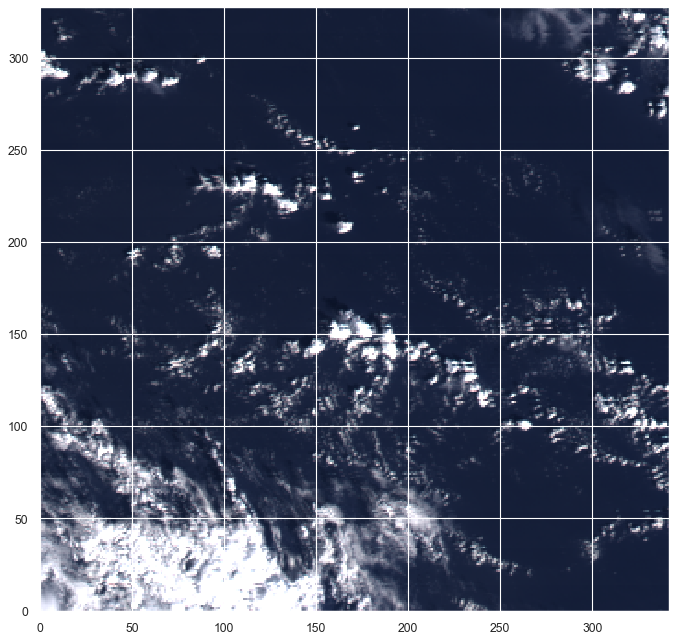

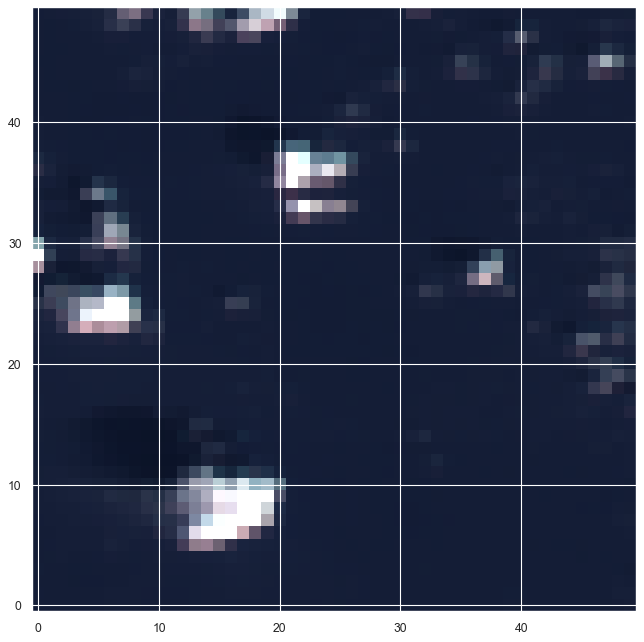

In [252]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

sub_data = rgb[293*2:457*2,912*2:1083*2]

#img = plt.imshow(np.fliplr(rgb[293*2:457*2,912*2:1083*2]), interpolation='nearest', origin='lower')
img = plt.imshow(sub_data, interpolation='nearest', origin='lower')
#img = plt.imshow(sub_data[200:250,150:200], interpolation='nearest', origin='lower')

#l = [int(i) for i in np.linspace(293*2,457*2,6)]
#plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

#l = [int(i) for i in np.linspace(912*2,1083*2,9)]
#plt.yticks(l, l, rotation=0, fontsize=11 )

#plt.xticks(fontsize=11)
#plt.yticks(fontsize=11)

plt.title('', fontsize=16)

plt.show()

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

#img = plt.imshow(np.fliplr(rgb[293*2:457*2,912*2:1083*2]), interpolation='nearest', origin='lower')
img = plt.imshow(sub_data[200:250,150:200], interpolation='nearest', origin='lower')

#l = [int(i) for i in np.linspace(293*2,457*2,6)]
#plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

#l = [int(i) for i in np.linspace(912*2,1083*2,9)]
#plt.yticks(l, l, rotation=0, fontsize=11 )

#plt.xticks(fontsize=11)
#plt.yticks(fontsize=11)

plt.title('', fontsize=16)

plt.show()

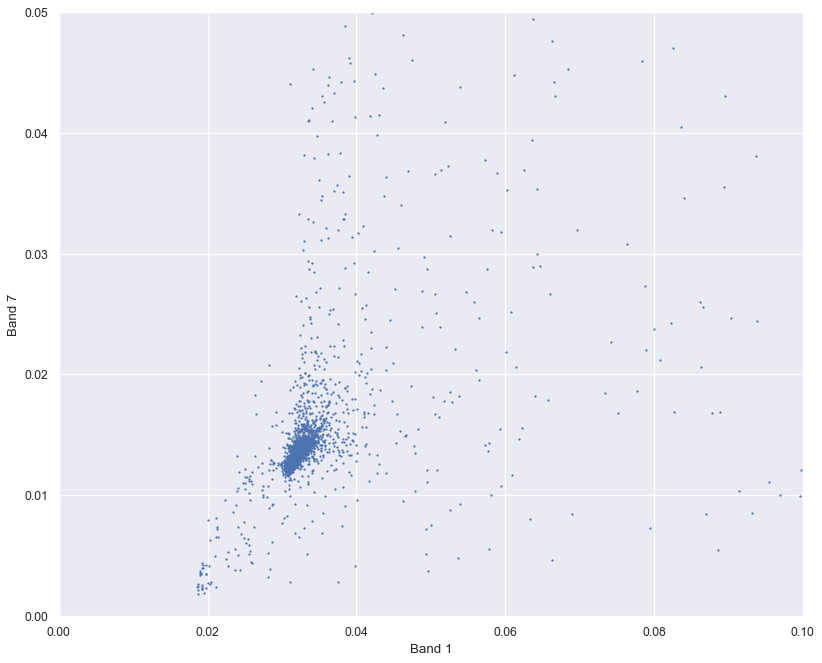

In [272]:
data_band1 = ( sds_data_250_Aggr1km_RefSB[0,:,:] - reflectance_offsets_250_Aggr1km_RefSB[0] ) * reflectance_scales_250_Aggr1km_RefSB[0] 
data_band6 = ( sds_data_500_Aggr1km_RefSB[3,:,:] - reflectance_offsets_500_Aggr1km_RefSB[3] ) * reflectance_scales_500_Aggr1km_RefSB[3] 
data_band7 = ( sds_data_500_Aggr1km_RefSB[4,:,:] - reflectance_offsets_500_Aggr1km_RefSB[4] ) * reflectance_scales_500_Aggr1km_RefSB[4] 

sub_data_band1 = data_band1[293*2:457*2,912*2:1083*2]
sub_data_band7 = data_band7[293*2:457*2,912*2:1083*2]


figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(sub_data_band1[200:250,150:200],sub_data_band7[200:250,150:200],s=1)

plt.xlabel('Band 1')
plt.ylabel('Band 7')

#plt.scatter(sub_data_band1[200:250,150:200][10:20,0:10],sub_data_band7[200:250,150:200][10:20,0:10],s=6)

plt.xlim(0.,0.1)
plt.ylim(0.0,0.05)

plt.show()



2.0
[[-0.00675102 -0.00651524 -0.00615164 ... -0.00667472 -0.00885154
  -0.0129842 ]
 [-0.00735781 -0.00632591 -0.00569973 ... -0.00699853 -0.00865101
  -0.00991356]
 [-0.0069031  -0.00652137 -0.00649585 ... -0.00632744 -0.00701946
  -0.00619349]
 ...
 [-0.00613224 -0.00528228 -0.00588013 ... -0.02710095 -0.0221308
  -0.00993369]
 [-0.00584135 -0.00583982 -0.00694315 ... -0.01366741 -0.01330654
  -0.01289955]
 [-0.00772141 -0.01247844 -0.02890951 ... -0.00711489 -0.00627413
  -0.00151609]]


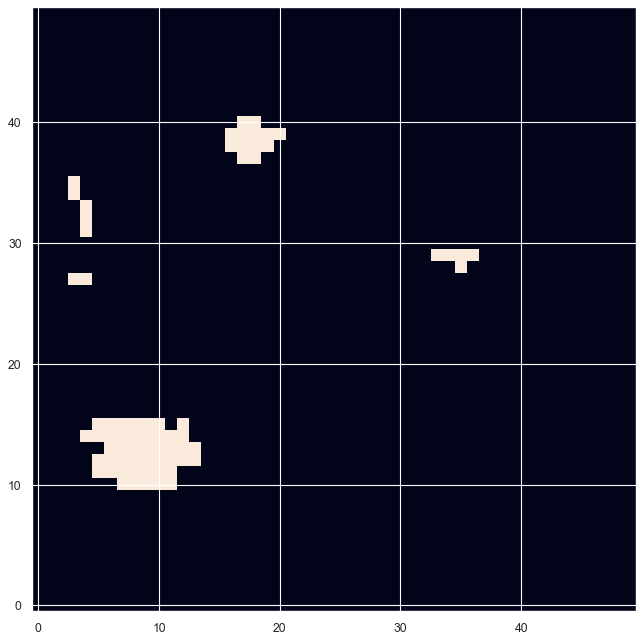

In [254]:
tmp_data1 = sub_data_band1[200:250,150:200]
tmp_data2 = sub_data_band7[200:250,150:200]

print(0.02 / 0.01)

tmp_data3 = np.zeros(tmp_data2.shape)

tmp_data3.shape

x1=0.0
y1=0.02

x2= 0.05
y2=0.

a = (y2-y1) / (x2-x1)
b = y2 - a * x2

print(a * tmp_data1 + b - tmp_data2)

#tmp_data3[ (tmp_data1 < 0.04) & (tmp_data2 < 0.01) ] = 1.0
tmp_data3[ (a * tmp_data1 + b - tmp_data2) > 0.0] = 1.0

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

img = plt.imshow(tmp_data3, interpolation='nearest', origin='lower')

plt.title('', fontsize=16)

plt.show()

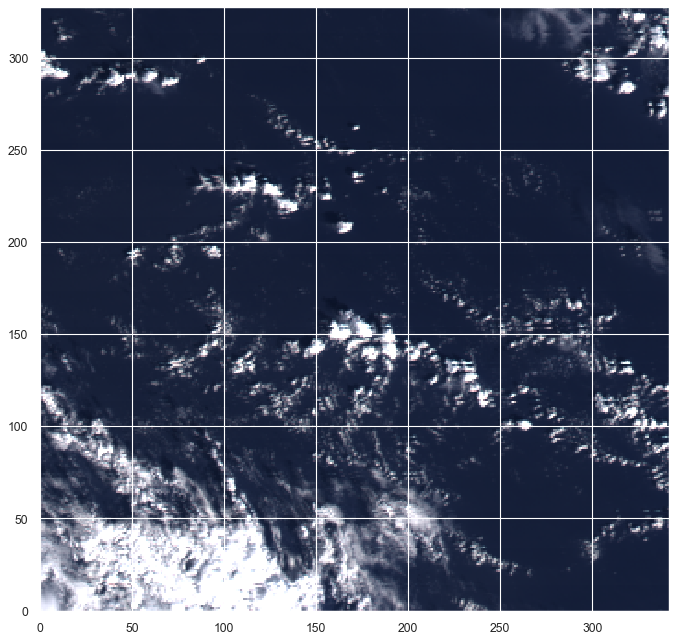

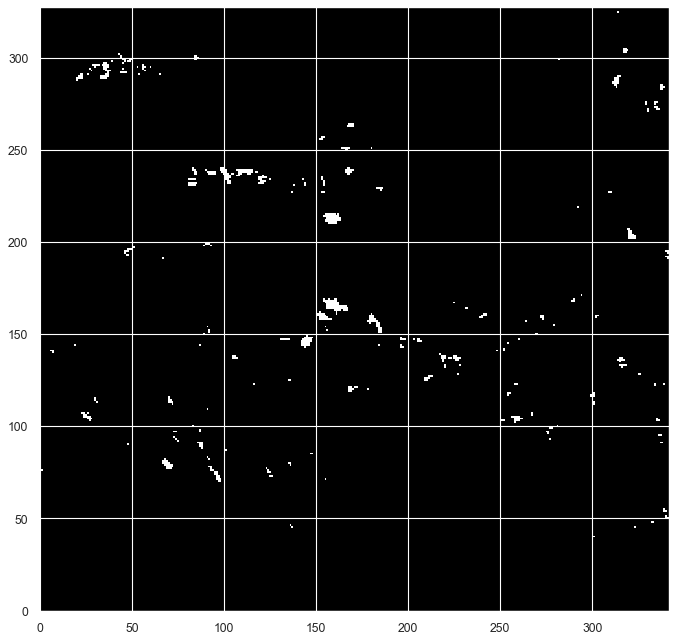

In [255]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

sub_data = rgb[293*2:457*2,912*2:1083*2]

#img = plt.imshow(np.fliplr(rgb[293*2:457*2,912*2:1083*2]), interpolation='nearest', origin='lower')
img = plt.imshow(sub_data, interpolation='nearest', origin='lower')
#img = plt.imshow(sub_data[200:250,150:200], interpolation='nearest', origin='lower')

#l = [int(i) for i in np.linspace(293*2,457*2,6)]
#plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

#l = [int(i) for i in np.linspace(912*2,1083*2,9)]
#plt.yticks(l, l, rotation=0, fontsize=11 )

#plt.xticks(fontsize=11)
#plt.yticks(fontsize=11)

plt.title('', fontsize=16)

plt.show()


tmp_data1 = sub_data_band1
tmp_data2 = sub_data_band7

tmp_data3 = np.zeros(sub_data.shape)

tmp_data3[ (a * tmp_data1 + b - tmp_data2) > 0.0] = 1.0

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

img = plt.imshow(tmp_data3, interpolation='nearest', origin='lower')

plt.title('', fontsize=16)

plt.show()

In [256]:
product = 'MYD03'

In [257]:
%%time

ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/{}/{:04d}/{:03d}.json'.format(product,year,count_of_day)

with urllib.request.urlopen(ladsweb_url) as url:
    data = json.loads(url.read().decode())

#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(data)

CPU times: user 12.7 ms, sys: 2.18 ms, total: 14.8 ms
Wall time: 5.7 s


In [258]:
file_name = ''
for file in data:
    #print(file['name'])
    file_name_prefix = '{}.A{:04d}{:03d}.{:02d}{:02d}'.format(product,year,count_of_day,hour,minute)
    if file_name_prefix in file['name']:
        file_name = file['name']      
        
print(file_name)

MYD03.A2012305.1445.061.2018041150653.hdf


In [259]:
if not path.exists(file_name):
    ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/{}/{:04d}/{:03d}/{}'.format(product,year,count_of_day,file_name)
    urllib.request.urlretrieve(ladsweb_url, file_name) 

In [260]:
myd02hkm_file = SD(file_name, SDC.READ)
    
datasets_dic = myd02hkm_file.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    print( idx,sds )

0 Latitude
1 Longitude
2 Scan Offset
3 Track Offset
4 Height Offset
5 Height
6 SensorZenith
7 SensorAzimuth
8 Range
9 SolarZenith
10 SolarAzimuth
11 Land/SeaMask
12 WaterPresent
13 gflags
14 Scan number
15 EV frames
16 SD frames
17 SV frames
18 EV start time
19 SD start time
20 SV start time
21 EV center time
22 Mirror side
23 SD Sun zenith
24 SD Sun azimuth
25 Moon Vector
26 L1 scan quality
27 Geo scan quality
28 orb_pos
29 orb_vel
30 T_inst2ECR
31 attitude_angles
32 sun_ref
33 num_impulse
34 impulse_enc
35 impulse_time
36 Scan Type
37 thermal_correction
38 attitude_quality
39 ephemeris_quality
40 Focal_length
41 band_position
42 detector_space
43 detector_offsets
44 T_offset
45 num_samples


{'_FillValue': -32767,
 'scale_factor': 0.01,
 'units': 'degrees',
 'valid_range': [-18000, 18000]}


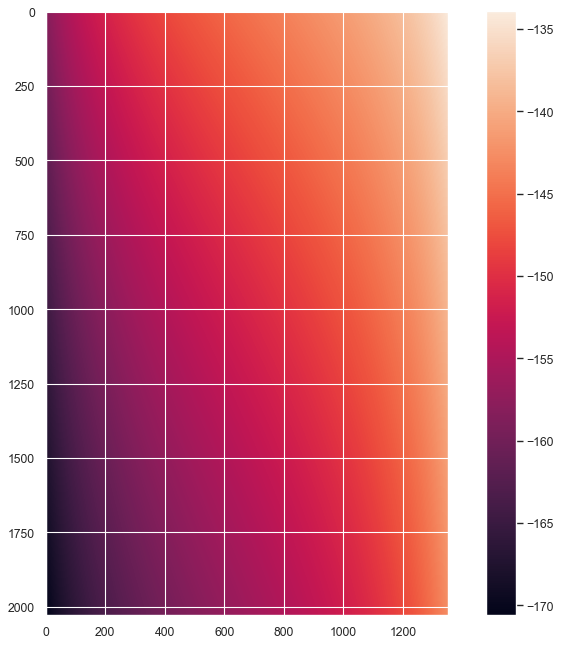

In [261]:
sds_obj = myd02hkm_file.select('SolarAzimuth') # select sds

import pprint

pprint.pprint( sds_obj.attributes() )

data = sds_obj.get() # get sds data

data = data * 0.01

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(np.fliplr(data))

plt.colorbar()

plt.show()

{'_FillValue': -32767,
 'scale_factor': 0.01,
 'units': 'degrees',
 'valid_range': [0, 18000]}


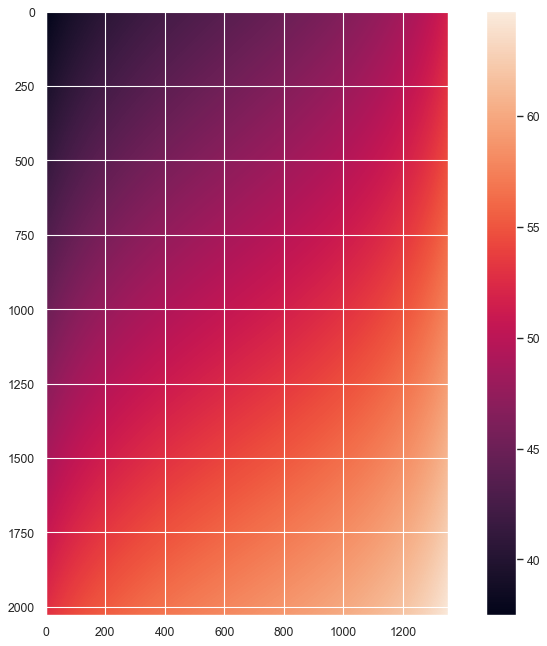

In [262]:
sds_obj = myd02hkm_file.select('SolarZenith') # select sds

import pprint

pprint.pprint( sds_obj.attributes() )

data = sds_obj.get() # get sds data

data = data * 0.01

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(np.fliplr(data))

plt.colorbar()

plt.show()

In [294]:
import math

x = np.linspace(-2, 2, 5)
y = np.linspace(-2, 2, 5)

xx, yy = np.meshgrid(x, y, sparse=False)

print(xx)
print(yy)

sun_azimuth_direction = (0,1)

theta = np.radians(-145.)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

print(R)

print(np.dot(R,sun_azimuth_direction))

sun_azimuth_direction = np.dot(R,sun_azimuth_direction)

[[-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]
 [-2. -1.  0.  1.  2.]]
[[-2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]]
[[-0.81915204  0.57357644]
 [-0.57357644 -0.81915204]]
[ 0.57357644 -0.81915204]


In [295]:
F = xx * sun_azimuth_direction[0] + yy * sun_azimuth_direction[1]

F

array([[ 0.49115122,  1.06472765,  1.63830409,  2.21188052,  2.78545696],
       [-0.32800083,  0.24557561,  0.81915204,  1.39272848,  1.96630492],
       [-1.14715287, -0.57357644,  0.        ,  0.57357644,  1.14715287],
       [-1.96630492, -1.39272848, -0.81915204, -0.24557561,  0.32800083],
       [-2.78545696, -2.21188052, -1.63830409, -1.06472765, -0.49115122]])

[[ 1.  1.  1.  1.  1.]
 [-1.  1.  1.  1.  1.]
 [-1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1.]]


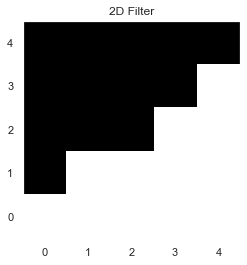

In [296]:
F[ F > 0.0 ] =1.0
F[ F <= 0.0 ] = -1.0

print(F)

plt.imshow(F,cmap='gist_gray', origin='lower')

plt.grid()

plt.title('2D Filter')

plt.show()

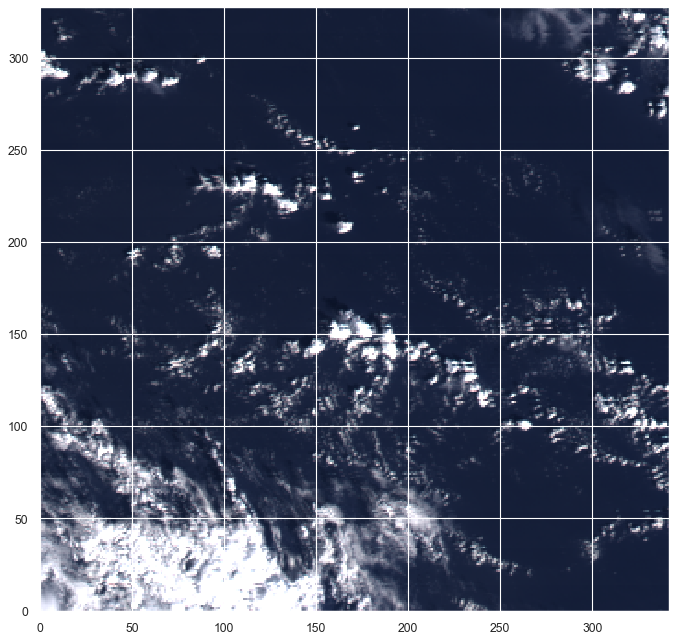

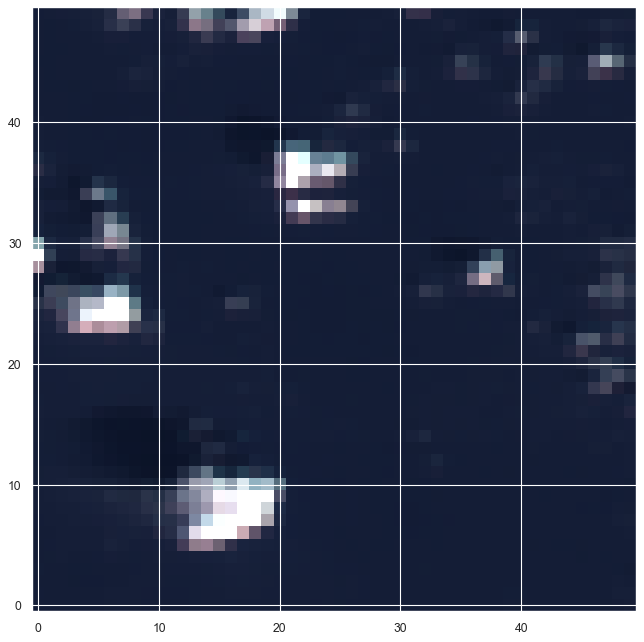

In [297]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

sub_data = rgb[293*2:457*2,912*2:1083*2]

#img = plt.imshow(np.fliplr(rgb[293*2:457*2,912*2:1083*2]), interpolation='nearest', origin='lower')
img = plt.imshow(sub_data, interpolation='nearest', origin='lower')
#img = plt.imshow(sub_data[200:250,150:200], interpolation='nearest', origin='lower')

#l = [int(i) for i in np.linspace(293*2,457*2,6)]
#plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

#l = [int(i) for i in np.linspace(912*2,1083*2,9)]
#plt.yticks(l, l, rotation=0, fontsize=11 )

#plt.xticks(fontsize=11)
#plt.yticks(fontsize=11)

plt.title('', fontsize=16)

plt.show()

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

#img = plt.imshow(np.fliplr(rgb[293*2:457*2,912*2:1083*2]), interpolation='nearest', origin='lower')
img = plt.imshow(sub_data[200:250,150:200], interpolation='nearest', origin='lower')

#l = [int(i) for i in np.linspace(293*2,457*2,6)]
#plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

#l = [int(i) for i in np.linspace(912*2,1083*2,9)]
#plt.yticks(l, l, rotation=0, fontsize=11 )

#plt.xticks(fontsize=11)
#plt.yticks(fontsize=11)

plt.title('', fontsize=16)

plt.show()

In [298]:
rgb_small_window = sub_data[200:250,150:200]

small_window_band1 = rgb_small_window[:,:,0]

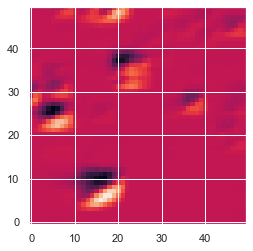

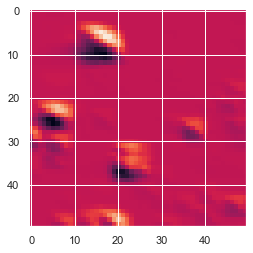

In [299]:
from scipy import signal

grad = signal.convolve2d(small_window_band1, F, boundary='symm', mode='same')

grad.shape

plt.imshow(grad, interpolation='nearest', origin='lower')

plt.show()

plt.imshow(grad)

plt.show()

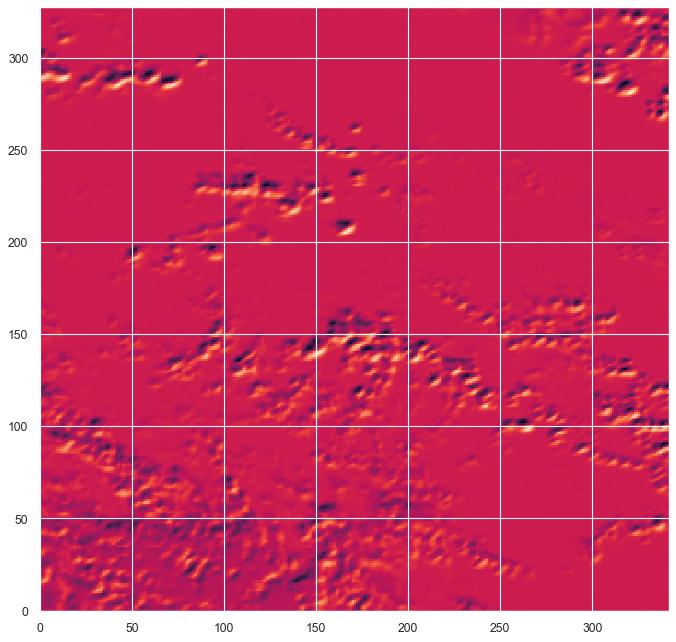

In [300]:
rgb_medium_window = np.copy(sub_data)

medium_window_band1 = rgb_medium_window[:,:,0]

grad = signal.convolve2d(medium_window_band1, F, boundary='symm', mode='same')

grad.shape

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(grad, interpolation='nearest', origin='lower')

plt.show()

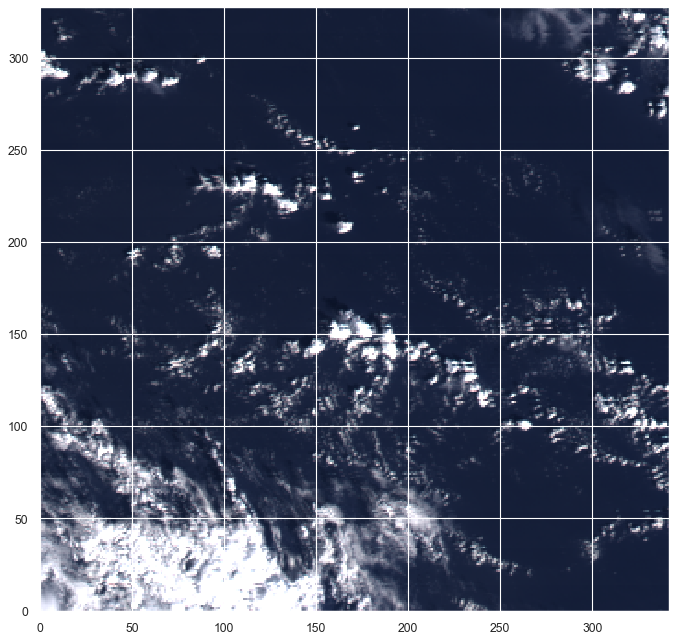

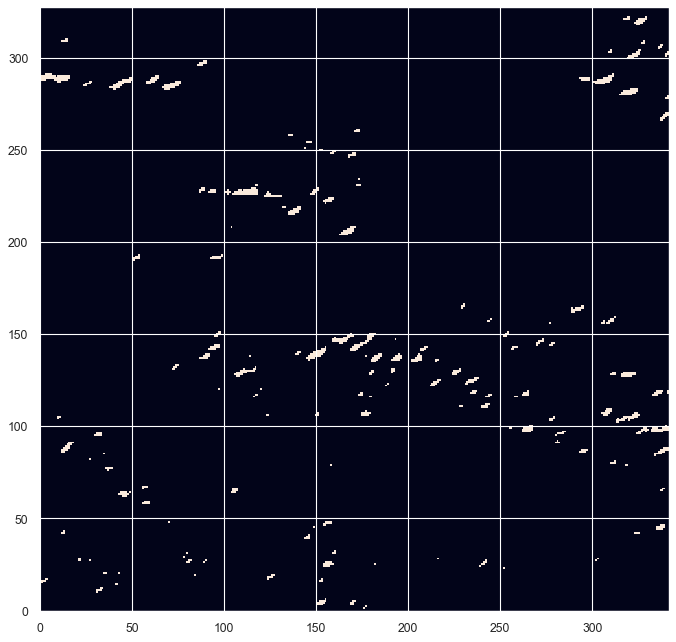

In [301]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

sub_data = rgb[293*2:457*2,912*2:1083*2]

#img = plt.imshow(np.fliplr(rgb[293*2:457*2,912*2:1083*2]), interpolation='nearest', origin='lower')
img = plt.imshow(sub_data, interpolation='nearest', origin='lower')
#img = plt.imshow(sub_data[200:250,150:200], interpolation='nearest', origin='lower')

#l = [int(i) for i in np.linspace(293*2,457*2,6)]
#plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )

#l = [int(i) for i in np.linspace(912*2,1083*2,9)]
#plt.yticks(l, l, rotation=0, fontsize=11 )

#plt.xticks(fontsize=11)
#plt.yticks(fontsize=11)

plt.title('', fontsize=16)

plt.show()




rgb_medium_window = np.copy(sub_data)

medium_window_band1 = rgb_medium_window[:,:,0]

grad = signal.convolve2d(medium_window_band1, F, boundary='symm', mode='same')

grad.shape

grad[ grad > 3.0 ] = 5.0
grad[ grad < 3.0 ] = -1.0

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(grad, interpolation='nearest', origin='lower')

plt.show()